In [46]:

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import pickle as pkl

%load_ext autoreload
%autoreload 2
from utils import *
from layers import *
from transformer import *
from cifar10 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# 0: Flugzeug
# 1: Auto
# 2: Vogel
# 3: Katze
# 4: Reh
# 5: Hund
# 6: Kröte
# 7: Pferd
# 8: Boot
# 9: Truck

labels = [
    'Plane',
    'Car',
    'Bird',
    'Cat',
    'Dog',
    'Deer',
    'Frog',
    'Horse',
    'Boat',
    'Truck'
]

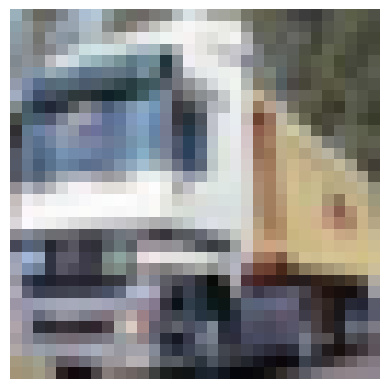

In [3]:
showimg(getimg(1))

In [47]:
NLATENT = 200

In [18]:

def batchgen(bsize=32, start=0):
    ep = 0
    while True:
        inds = np.random.permutation(range(start, N))
        minibatches = [ inds[k*bsize:(k+1)*bsize] for k in range(len(inds)//bsize) ]
        for mb in minibatches:
            xs = np.zeros((bsize, 3, 32, 32))
            zs = np.zeros((bsize), dtype=int)
            for i, j in enumerate(mb):
                x = getimg(j).reshape((32, 32, -1))
                xs[i] = x.transpose(2, 0, 1)
                zs[i] = getlabel(j)
            yield xs, zs
        print(f'========== EPOCH {ep} COMPLETED ==========')
        ep += 1

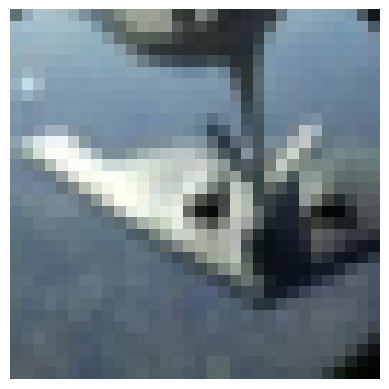

In [49]:
bg = batchgen()
xs, zs = next(bg)
xs.shape
showimg(xs[0])

In [50]:

class Encoder(nn.Module):
    def __init__(self, n, nlatent):
        super().__init__()
        self.conv1 = nn.Conv2d(13, n, 4, 2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(n)
        self.conv2 = nn.Conv2d(n, 2*n, 4, 2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(2*n)
        self.convlast = nn.Conv2d(2*n, 2*nlatent, 1, 1, padding=0, bias=True)
        self.cuda()
    def forward(self, x, z=None, d=4):
        if z is None:
            z = torch.zeros(len(x), 10).cuda()
        z = z[:,:,None,None].repeat(1, 1, 32, 32)
        x = x-0.5
        x = torch.cat([x, z], 1)           # Output
        x = relu(self.bn1(self.conv1(x)))  # 64x16x16
        if d==1: return x
        x = relu(self.bn2(self.conv2(x)))  # 128x8x8
        x = self.convlast(x)
        return x

In [51]:

class Decoder(nn.Module):
    def __init__(self, n, nlatent):
        super().__init__()
        self.conv0 = nn.Conv2d(nlatent+10, 2*n, 1, 1, bias=False)
        self.bn0 = nn.BatchNorm2d(2*n)
        self.conv3 = nn.ConvTranspose2d(2*n, n, 4, 2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(n)
        self.conv4 = nn.ConvTranspose2d(n, n, 3, 1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(n)
        self.convlast = nn.ConvTranspose2d(n, 3, 4, 2, padding=1, bias=True)
        self.cuda()
    def forward(self, x, z=None, d=99999):
        if z is None:
            z = torch.zeros(len(x), 10).cuda()
        if d>=2:
            x = torch.cat((x, z[:,:,None,None].repeat(1,1,8,8)), 1)  # Input
            x = relu(self.bn0(self.conv0(x)))        # 20x1x1
            x = relu(self.bn3(self.conv3(x)))
        if d>=1:
            x = relu(self.bn4(self.conv4(x)))
            x = F.sigmoid(self.convlast(x))
        return x

In [52]:
class Net(nn.Module):
    def __init__(self, n, nlatent):
        super().__init__()
        self.enc = Encoder(n, nlatent)
        self.dec = Decoder(n, nlatent)
        self.nlatent = nlatent
    def forward(self, x, z=None, d=2, train=True):
        x = self.enc(x, z, d)
        if d >= 2:
            mu = x[:,:self.nlatent]
            logvar = x[:,self.nlatent:]
            std = torch.exp(logvar/2)
            eps = torch.randn_like(std) if train else 0
        else:
            mu, logvar = x, 0
            std = 0
            eps = 0
        x = mu + eps*std
        x = self.dec(x, z, d)
        return x, mu, logvar

In [53]:
from torchsummary import summary
net = Net(64, NLATENT)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]          13,312
       BatchNorm2d-2           [-1, 64, 16, 16]             128
            Conv2d-3            [-1, 128, 8, 8]         131,072
       BatchNorm2d-4            [-1, 128, 8, 8]             256
            Conv2d-5            [-1, 400, 8, 8]          51,600
           Encoder-6            [-1, 400, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          26,880
       BatchNorm2d-8            [-1, 128, 8, 8]             256
   ConvTranspose2d-9           [-1, 64, 16, 16]         131,072
      BatchNorm2d-10           [-1, 64, 16, 16]             128
  ConvTranspose2d-11           [-1, 64, 16, 16]          36,864
      BatchNorm2d-12           [-1, 64, 16, 16]             128
  ConvTranspose2d-13            [-1, 3, 32, 32]           3,075
          Decoder-14            [-1, 3,

In [54]:
from torch_optimizer import Lookahead, Yogi
net = Net(64, 20)
net.optim = Lookahead(Yogi(net.parameters(), lr=3e-3, betas=(0.9, 0.99)))
net.iters = 0
net.losses1 = []
net.losses2 = []
net.vlosses = []
bg = batchgen()

In [55]:
def onehot(zs):
    ys = np.zeros((len(zs), 10))
    for i in range(len(zs)):
        ys[i, zs[i]] = 1.
    return ys


def valloss():
    bsize = 200
    xs = np.zeros((bsize, 3, 32, 32))
    zs = np.zeros((bsize), dtype=int)
    for i in range(bsize):
        x = getimg(i).reshape((32, 32, -1))
        xs[i] = x.transpose(2, 0, 1)
        zs[i] = getlabel(i)
    zs = onehot(zs)
    xs, zs = np2t(xs, zs)
    xs2, mu, logvar = net(xs, zs)
    pixelloss = torch.mean((xs-xs2)**2) + torch.mean(torch.abs(xs-xs2))/10
    klloss = 0.5 * torch.mean(-1 - logvar + mu**2/5 + torch.exp(logvar))
    return pixelloss + klloss
    
def loss(d=9999):
    xs, zs = next(bg)
    zs = onehot(zs)
    xs, zs = np2t(xs, zs)
    xs2, mu, logvar = net(xs, zs, d=d, train=True)
    pixelloss = torch.mean((xs-xs2)**2) + torch.mean(torch.abs(xs-xs2))/10
    klloss = 0.5 * torch.mean(-1 - logvar + mu**2/5 + torch.exp(logvar)) if not isinstance(logvar, int) else torch.tensor(0)
    return pixelloss, klloss/10

valloss(), loss()

(tensor(0.1795, device='cuda:0', grad_fn=<AddBackward0>),
 (tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)))

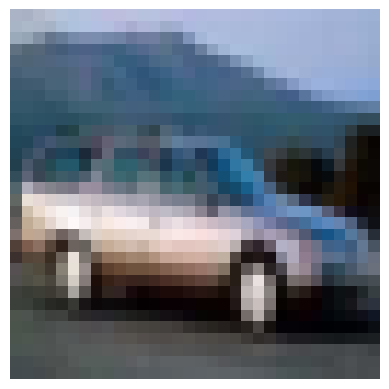

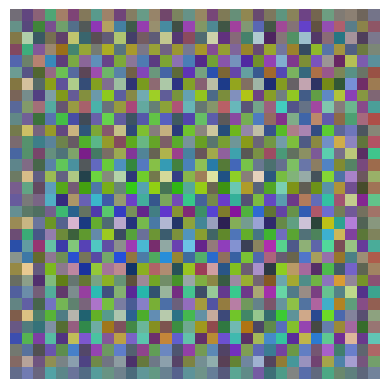

In [56]:
def showexample(i=1, d=9999):
    bsize = 10
    xs = np.zeros((bsize, 3, 32, 32))
    zs = np.zeros((bsize), dtype=int)
    for j in range(bsize):
        x = getimg(j).reshape((32, 32, -1))
        xs[j] = x.transpose(2, 0, 1)
        zs[j] = getlabel(j)
    zs = onehot(zs)
    xs, zs = np2t(xs, zs)
    xs2, mu, logvar = net(xs, zs, d=d, train=False)
    
    xs, xs2 = t2np(xs, xs2)
    showimg(xs[i])
    plt.show()
    showimg(xs2[i])
    plt.show()
    
showexample(4, d=6)

  0%|          | 0/999999 [00:00<?, ?it/s]

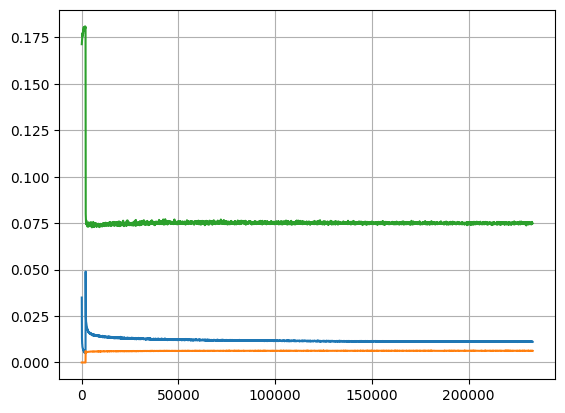

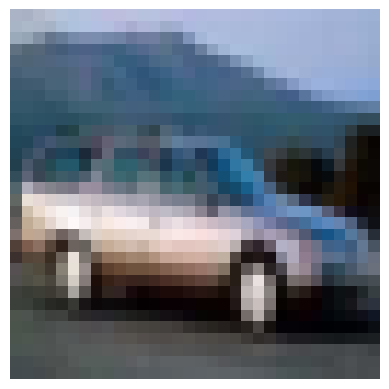

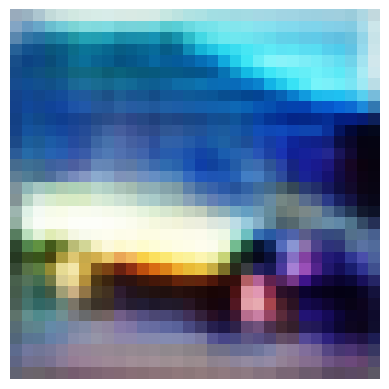

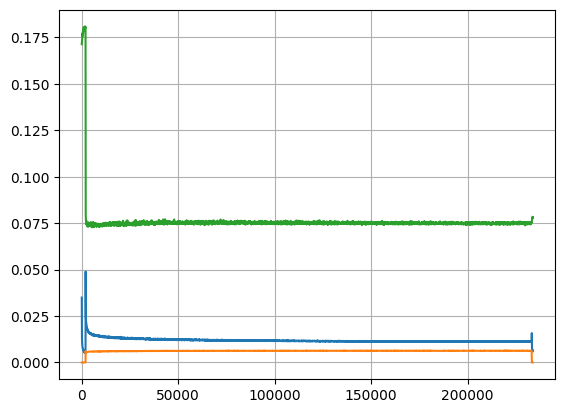

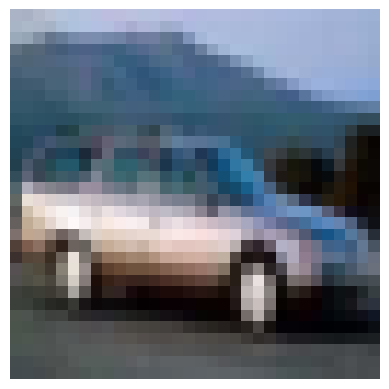

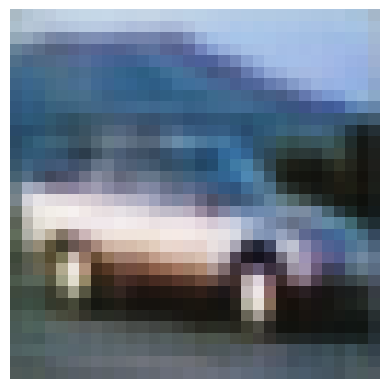

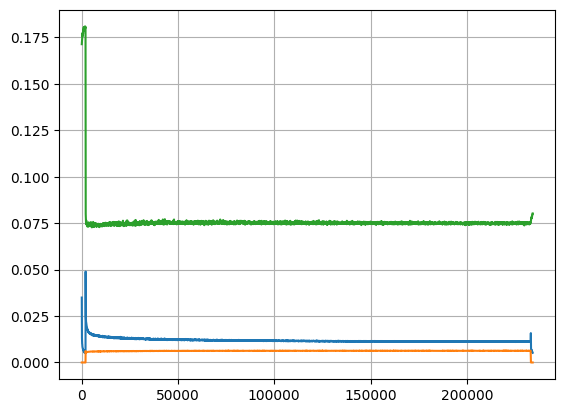

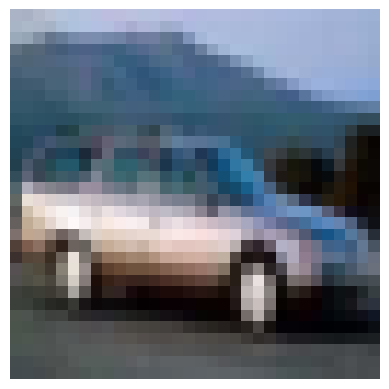

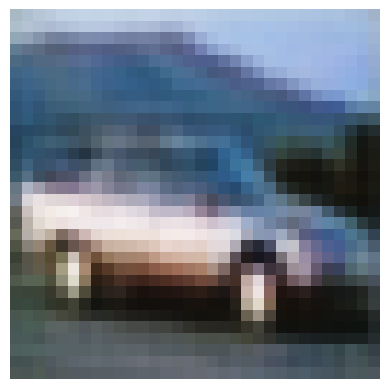

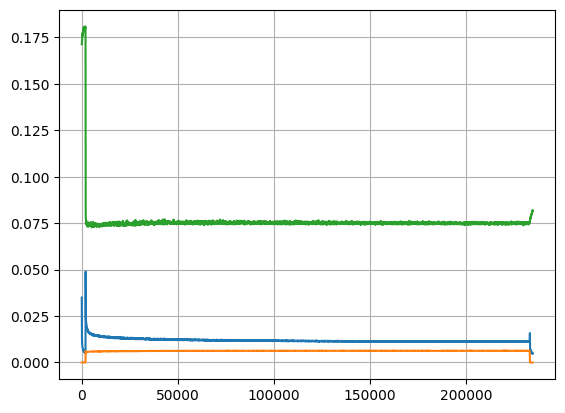

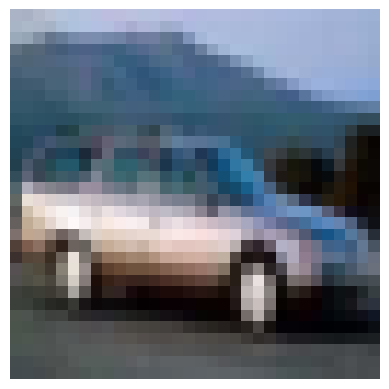

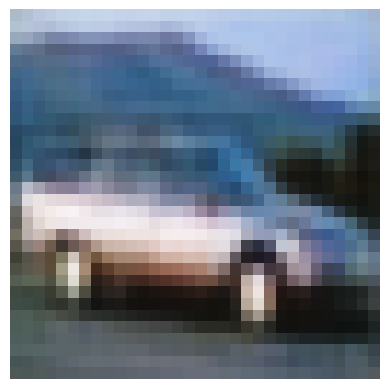

========== EPOCH 0 COMPLETED ==========


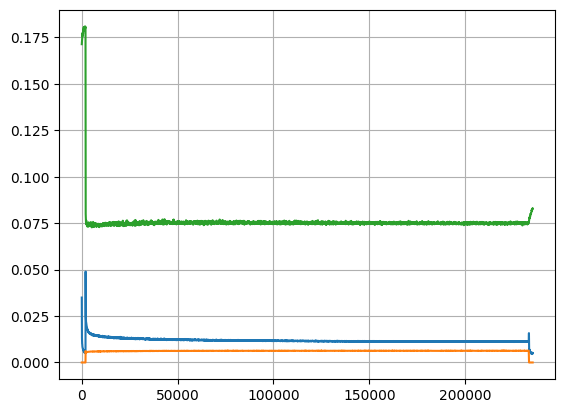

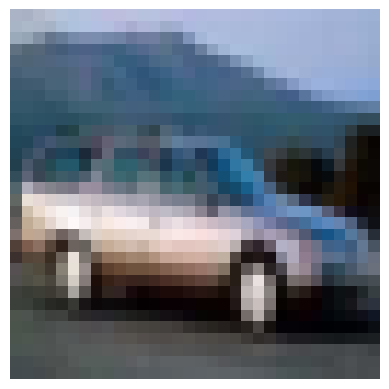

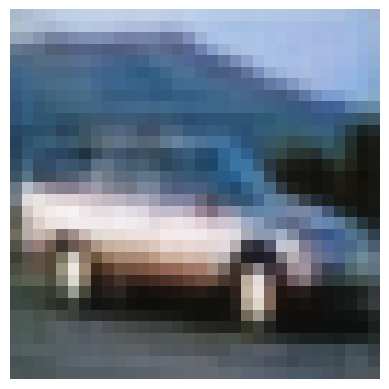

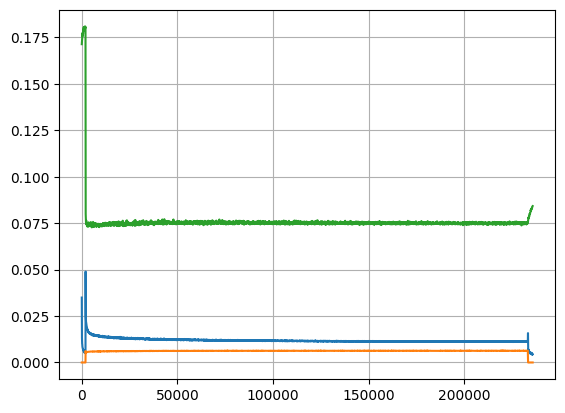

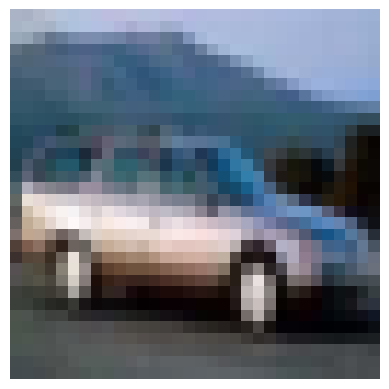

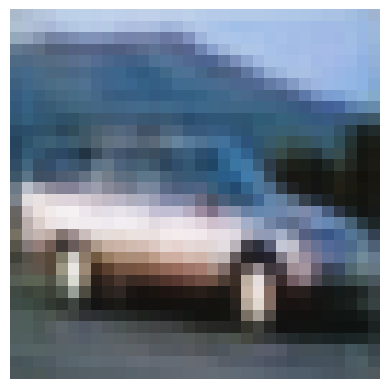

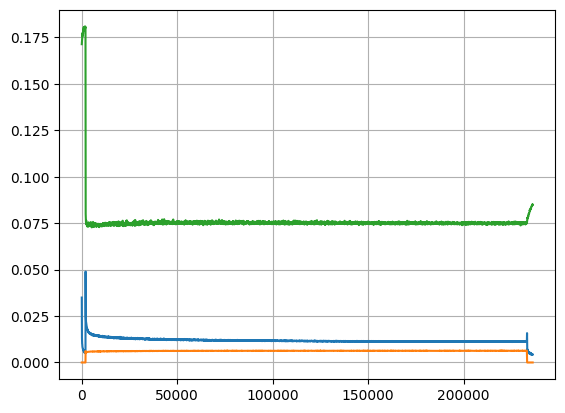

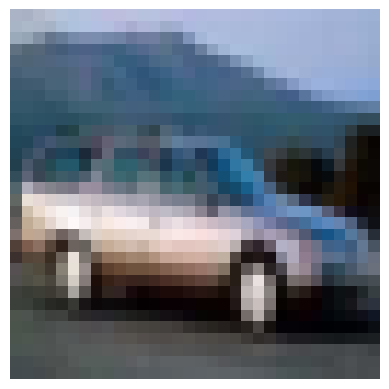

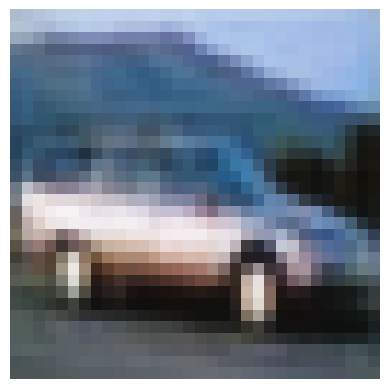

========== EPOCH 1 COMPLETED ==========


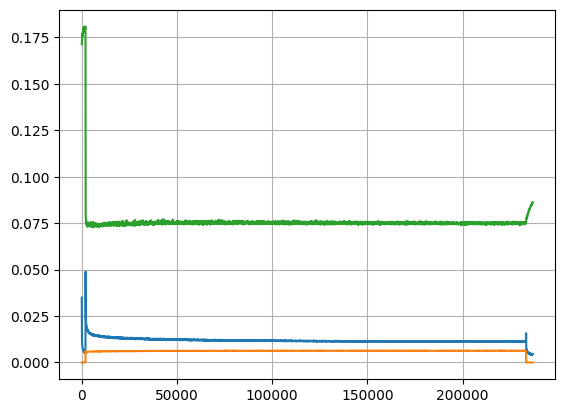

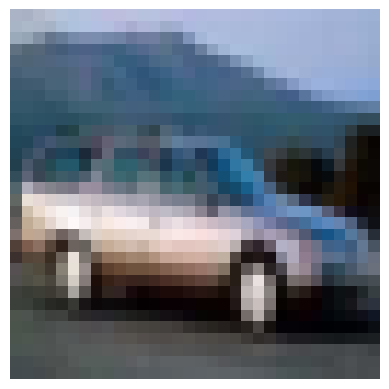

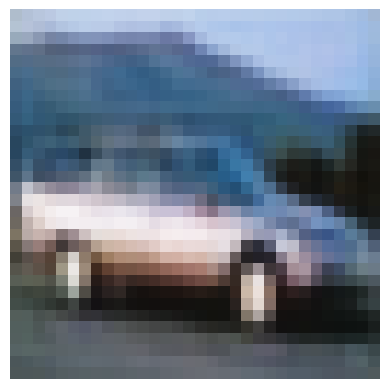

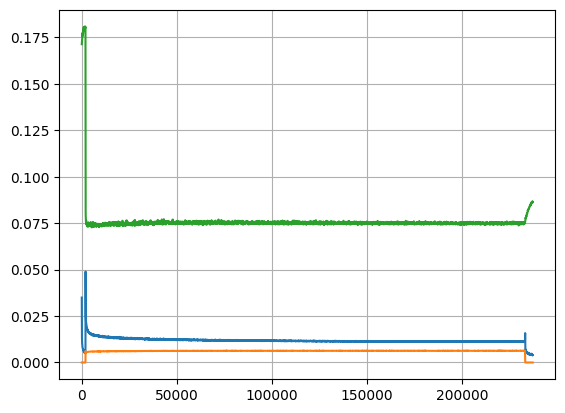

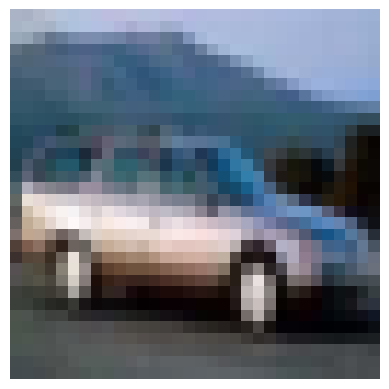

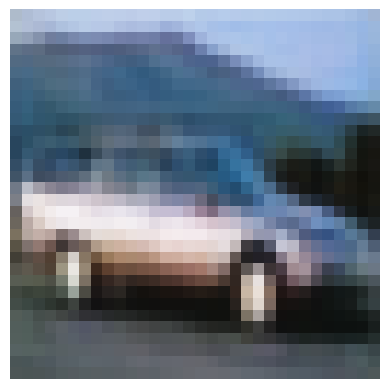

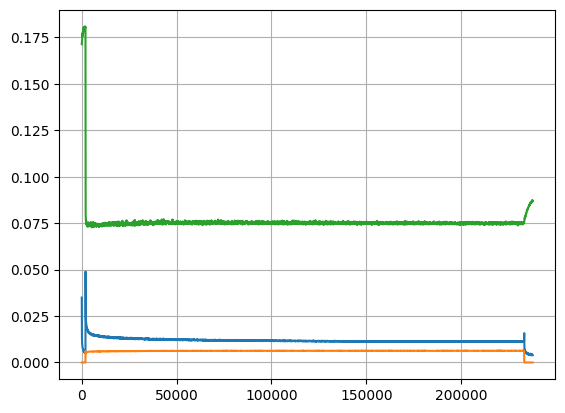

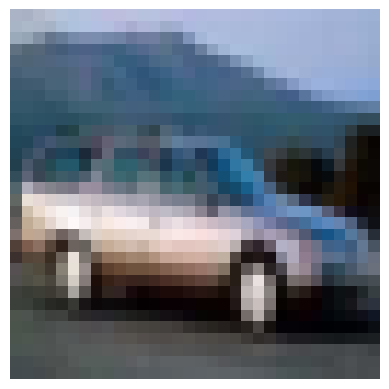

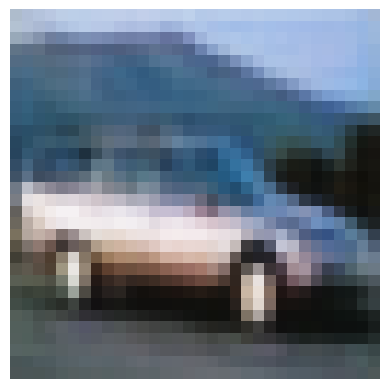

========== EPOCH 2 COMPLETED ==========


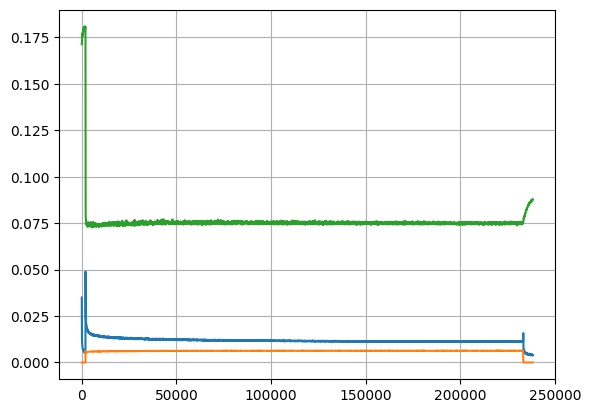

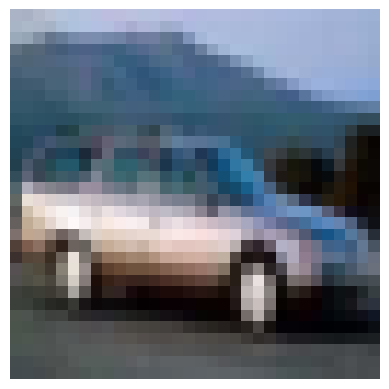

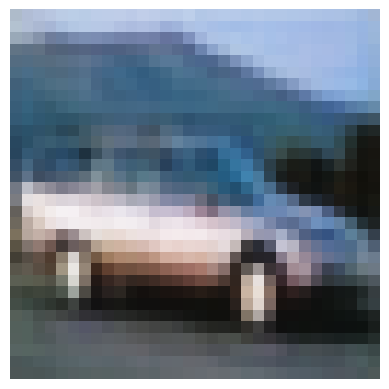

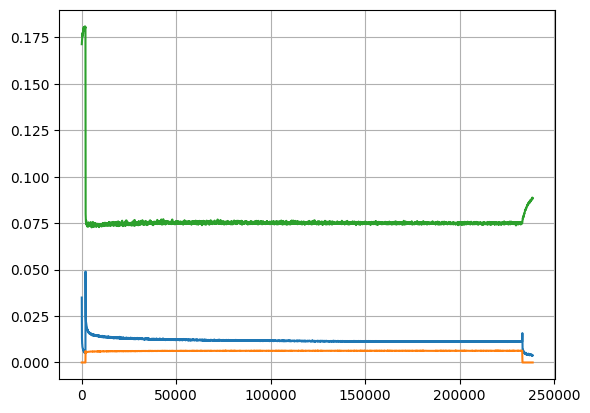

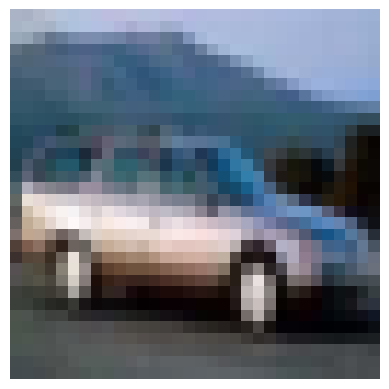

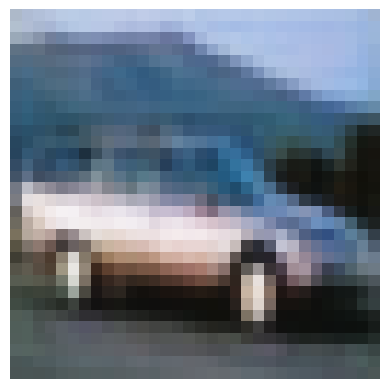

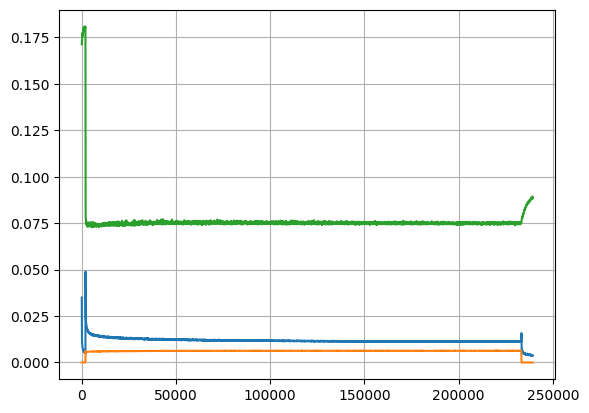

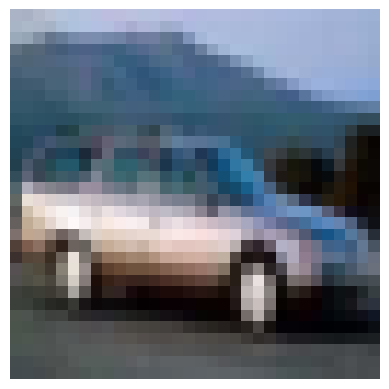

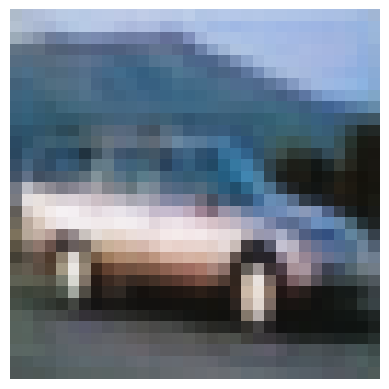

========== EPOCH 3 COMPLETED ==========


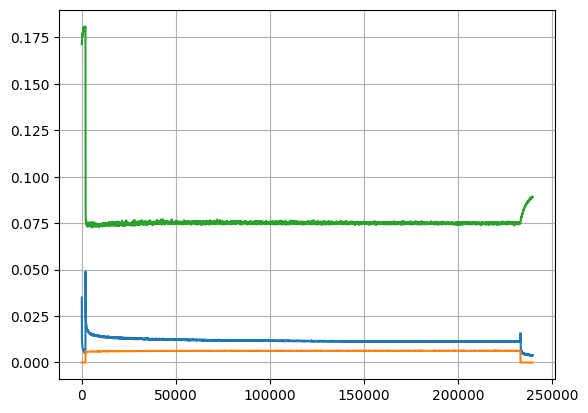

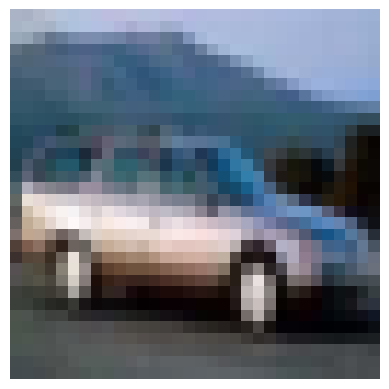

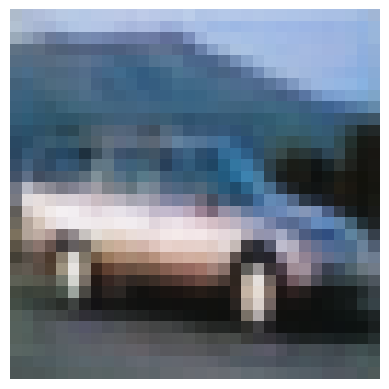

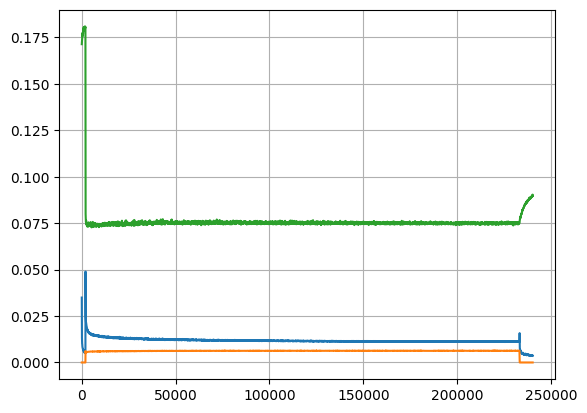

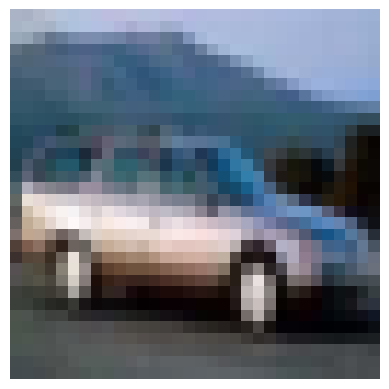

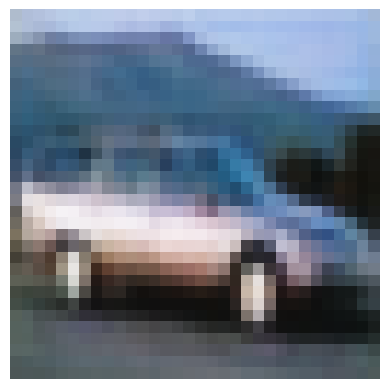

KeyboardInterrupt: 

In [60]:
losses1 = []
losses2 = []
bg = batchgen()

for k in trange(999999):
    d = net.iters // 2000 + 1
    d = 1
    net.train()
    l1, l2 = loss(d)
    (l1+l2).backward()
    losses1.append(l1.item())
    losses2.append(l2.item())
    net.optim.step()
    net.zero_grad()

    if len(losses1) == 50:
        net.vlosses.append((net.iters, valloss().item()))
        net.losses1.append((net.iters, np.mean(losses1)))
        net.losses2.append((net.iters, np.mean(losses2)))
        losses1 = []
        losses2 = []
        #slosses = []

    if k % 500 == 0:
        plt.plot(*zip(*net.losses1))
        plt.plot(*zip(*net.losses2))
        plt.plot(*zip(*net.vlosses))
        plt.grid()
        plt.show()
        showexample(4, d)

    net.iters += 1

In [28]:
torch.save(net.state_dict(), 'vae_light_171223.dat')

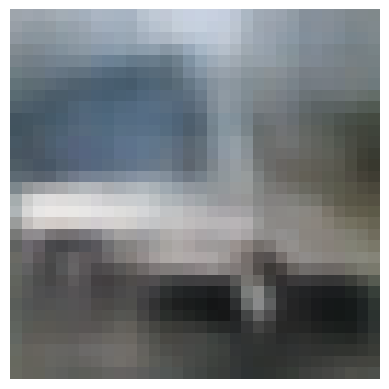

In [58]:
bsize = 10
xs = np.zeros((bsize, 3, 32, 32))
zs = np.zeros((bsize), dtype=int)
for j in range(bsize):
    x = getimg(j).reshape((32, 32, -1))
    xs[j] = x.transpose(2, 0, 1)
    zs[j] = getlabel(j)
zs = onehot(zs)
xs, zs = np2t(xs, zs)

lat = net.enc(xs)
mu = lat[:,:20]

t = 0.5
mu[0] = mu[1]*(1-t) + mu[4]*t

xs = net.dec(mu)

xs = t2np(xs)
showimg(xs[0])
plt.show()

In [74]:
np.array(net.losses)[:,1]

array([0.10555216, 0.0876251 , 0.08570125, ..., 0.07183116, 0.0719355 ,
       0.07134622])

(0.6, 0.7)

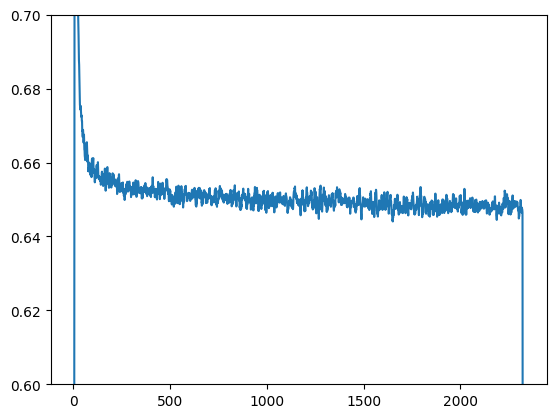

In [77]:
plt.plot(np.convolve(np.array(net.losses)[:,1], [1, 1, 1, 1, 1, 1, 1, 1, 1]))
plt.ylim([0.6, 0.7])